# Names Classification with PyTorch

### Import Libs

In [66]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import string

import torch
import torch.nn as nn

### Options

In [67]:
! sudo apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.2).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [68]:
# ! unzip data/pytorch-names.zip

### Data

In [69]:
def findFiles(path): 
    return glob.glob(path)

In [70]:
print(findFiles('data/names/*.txt'))

['data/names/Arabic.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/German.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt']


In [71]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [72]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [73]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [74]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [75]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [76]:
all_categories

['Arabic',
 'Portuguese',
 'Spanish',
 'Irish',
 'Scottish',
 'German',
 'Chinese',
 'English',
 'Korean',
 'Czech',
 'Russian',
 'Italian',
 'Dutch',
 'French',
 'Japanese',
 'Greek',
 'Polish',
 'Vietnamese']

In [77]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [78]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [79]:
letterToIndex('m')

12

In [80]:
letterToTensor('m')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [81]:
lineToTensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

### Model

In [103]:
class RNNClassic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassic, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
        
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [96]:
class RNNTorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(RNNTorch, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        hidden = self.init_hidden(batch_size)
        
        output, hidden = self.rnn(x, hidden)
        
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        
        return output, hidden
        
    def init_hidden(self):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden

In [97]:
n_hidden = 128

In [98]:
print(n_letters, n_hidden, n_categories)

57 128 18


In [104]:
rnn = RNNClassic(n_letters, n_hidden, n_categories)

In [99]:
# rnn = RNNTorch(n_letters, n_hidden, n_categories, n_layers=1)

In [100]:
print(rnn)

RNNTorch(
  (rnn): RNN(57, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
)


### Letter

In [46]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [47]:
output, next_hidden

(tensor([[-2.9266, -2.9272, -2.8324, -2.9632, -2.9167, -2.8060, -2.9261, -2.8726,
          -2.8077, -2.9223, -2.9237, -2.8072, -2.9031, -2.8524, -2.8834, -2.8549,
          -3.0109, -2.9176]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[-0.0215,  0.0647,  0.0658, -0.0308,  0.0173, -0.0278,  0.0191, -0.0027,
          -0.0090,  0.1397,  0.0748,  0.1061,  0.0973,  0.0663,  0.0507,  0.0243,
           0.0255,  0.0911, -0.0579, -0.0548,  0.0182, -0.0932,  0.0006,  0.0178,
          -0.0505,  0.0672, -0.0639,  0.0620,  0.0743,  0.0034,  0.0604, -0.1244,
          -0.0236, -0.0337, -0.0981, -0.1068,  0.0420, -0.0139, -0.0757, -0.0157,
           0.0116,  0.1010,  0.0421,  0.0751,  0.0472, -0.0273,  0.0326,  0.0348,
           0.0826,  0.0063, -0.0219, -0.0434, -0.0002,  0.0595,  0.0896, -0.0598,
          -0.0615, -0.0111,  0.0523,  0.0220,  0.0488, -0.0259, -0.0045, -0.0472,
           0.0518,  0.0433, -0.0826,  0.0338, -0.0117, -0.0702, -0.0486, -0.0905,
          -0.0342,  0.0599,  0.0908,

### Name

In [50]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9266, -2.9272, -2.8324, -2.9632, -2.9167, -2.8060, -2.9261, -2.8726,
         -2.8077, -2.9223, -2.9237, -2.8072, -2.9031, -2.8524, -2.8834, -2.8549,
         -3.0109, -2.9176]], grad_fn=<LogSoftmaxBackward0>)


In [51]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 5)


In [53]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Yoshizawa
category = German / line = Eberhardt
category = Russian / line = Elehin
category = Russian / line = Pridvorov
category = English / line = Howes
category = Vietnamese / line = Tieu
category = Italian / line = Bove
category = French / line = Faucher
category = English / line = Templeman
category = Chinese / line = Ming


### Training

In [54]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
- Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [56]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [58]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.7259 Villa / Japanese ✗ (Italian)
10000 10% (0m 17s) 2.4269 Vliert / French ✗ (Dutch)
15000 15% (0m 26s) 2.6420 Sienkiewicz / Russian ✗ (Polish)
20000 20% (0m 34s) 1.5985 Kraemer / German ✓
25000 25% (0m 42s) 2.5446 Pelletier / German ✗ (French)
30000 30% (0m 51s) 0.3091 Niijima / Japanese ✓
35000 35% (0m 59s) 0.6751 Sowka / Polish ✓
40000 40% (1m 8s) 0.6232 Roijakkers / Dutch ✓
45000 45% (1m 16s) 2.0589 Kann / Irish ✗ (Dutch)
50000 50% (1m 25s) 2.2857 Docherty / English ✗ (Scottish)
55000 55% (1m 33s) 0.0110 Mcmillan / Scottish ✓
60000 60% (1m 42s) 2.9467 Simoes / Arabic ✗ (Portuguese)
65000 65% (1m 50s) 1.6769 Simoes / Dutch ✗ (Portuguese)
70000 70% (1m 59s) 0.1926 Lyzlov / Russian ✓
75000 75% (2m 8s) 0.8287 Gorecki / Polish ✓
80000 80% (2m 17s) 2.6446 Buchholz / Irish ✗ (German)
85000 85% (2m 25s) 3.4483 Jippensha / Czech ✗ (Japanese)
90000 90% (2m 35s) 4.7273 Gerstle / Polish ✗ (German)
95000 95% (2m 45s) 0.1853 Mackenzie / Scottish ✓
100000 100% (2m 53s) 0.3523 C

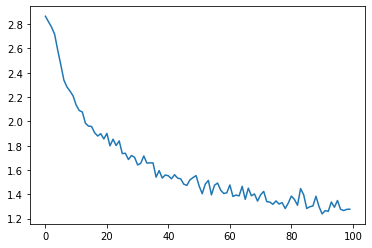

In [60]:
plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


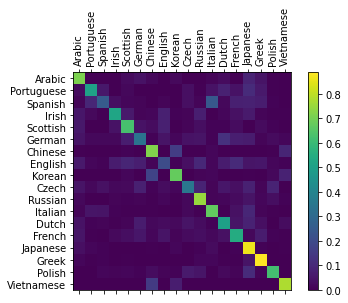

In [61]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [62]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [63]:
predict('Dovesky')


> Dovesky
(-0.23) Russian
(-1.78) Czech
(-4.35) English


In [64]:
predict('Jackson')


> Jackson
(-0.35) Scottish
(-1.73) Russian
(-2.69) English


In [65]:
predict('Satoshi')


> Satoshi
(-0.55) Japanese
(-2.02) Polish
(-2.24) Arabic
